# Enrichment Analysis Notebook

Compares the results of SPINDOCTOR gene set summarization vs statistical ontological enrichment.

Draft: https://docs.google.com/document/d/1H103ux6Dd1_bPM0un4RwutBLcYJx-0ybil2AwlAvG_Q/edit#

## Initial setup

Here we take care of imports, defining the data dictionary for the pandas dataframes

In [1]:
# parameters
experiment_results = "analysis/enrichment-summary.yaml"

In [2]:
import yaml
from yaml import Loader
import pandas as pd
from oaklib import get_adapter
from oaklib.datamodels.vocabulary import IS_A, PART_OF
from ontogpt.evaluation.enrichment.eval_enrichment import EvalEnrichment
go = get_adapter("sqlite:obo:go")
hgnc = get_adapter("sqlite:obo:hgnc")

In [3]:
#from ontogpt.utils.gene_set_utils import populate_ids_and_symbols, GeneSet
#ee = EvalEnrichment()
#ee.ontology = go
#ee.load_annotations("../tests/input/genes2go.tsv.gz")

In [4]:
# data dictionary
MODEL = "model"
METHOD = "method"
HAS_TOP_HIT = "has top hit"
IN_TOP_5 = "in top 5"
IN_TOP_10 = "in top 10"
RANK = "rank"
SIZE_OVERLAP = "size overlap"
SIMILARITY = "similarity"
NR_SIZE_OVERLAP = "nr size overlap"
NR_SIMILARITY = "nr similarity"
GENESET = "geneset"
SOURCE_GENESET = "source geneset"
GENESET_SIZE = "geneset_size"
TRUNCATION_FACTOR = "truncation factor"
NUM_TERMS = "num terms"
NUM_GO_TERMS = "num GO terms"
NUM_UNPARSED = "num unparsed"
TERM_IDS = "term ids"
GO_TERM_IDS = "go term ids"
GO_TERM_P_VALUES = "go term p values"
MAX_P_VALUE = "max p value"
MIN_P_VALUE = "min p value"
MEAN_P_VALUE = "mean p value"
PROPOTION_SIGNIFICANT = "proportion significant"
NOVEL = "novel"
NOVEL_LABELS = "novel labels"
NUM_NOVEL = "num novel"
GENE_RANDOMIZATION_FACTOR = "gene_randomization_factor"


TURBO = "gpt-3.5-turbo"
DAVINCI = "text-davinci-003"
MODELS = [TURBO, DAVINCI]

In [5]:
from ontogpt.evaluation.enrichment.eval_enrichment import GeneSetComparison

In [6]:
# assumes comparisons have been run and concatenated (see Makefile) 
def load_comparisons():
    with open(f"../{experiment_results}") as f:
        obj = yaml.load(f, Loader)
        comps = [GeneSetComparison(**x) for x in obj]
        return comps

In [7]:
comps = load_comparisons()

In [8]:

def filter_redundant(term_ids):
    """
    find leaf nodes in a set of term ids
    """
    cumulative_ancs = set()
    visited = set()
    for t in term_ids:
        visited.add(t)
        if t in cumulative_ancs:
            # a descendant of t has been encountered
            continue
        ancs = list(go.ancestors(t, [IS_A, PART_OF]))
        cumulative_ancs.update(ancs)
        if (visited-{t}).intersection(ancs):
            # t is a descendant of a term that has been encountered
            continue
        yield t

# test
list(filter_redundant(["GO:0005773", "GO:0005634", "GO:0031965", "GO:0008150"]))

['GO:0005773', 'GO:0005634', 'GO:0008150']

In [9]:
import statistics
import re
def eval_payload(comp, payload, expected, closure):
    """
    Create a dataframe row from a payload in a comparison
    """
    expected_nr_ids = list(filter_redundant(expected.term_ids))
    name = comp.name
    model = payload.model
    method = payload.method
    if not model:
        model = "N/A"
    tf = payload.truncation_factor
    if not tf:
        tf = 1.0
    unparsed_term_ids = [t for t in payload.term_ids if not re.match(r'^\S+:w+$', t)]
    go_term_ids = [t for t in payload.term_ids if t.startswith("GO:")]
    nr_term_ids = list(filter_redundant(go_term_ids))
    obj = {MODEL: model, METHOD: method, GENESET: name, TRUNCATION_FACTOR: tf}
    name_toks = name.split("-")
    obj[SOURCE_GENESET] = "-".join(name_toks[0:-1])
    obj[GENE_RANDOMIZATION_FACTOR] = int(name_toks[-1])
    if not expected.term_ids:
        #print(f"Nothing expected for {name}")
        # top_term_id = "FAKE:123"
        return
    else:
        top_term_id = expected.term_ids[0]
    obj[HAS_TOP_HIT] = top_term_id in payload.term_ids
    in_top_5 = False
    in_top_10 = False
    if top_term_id in payload.term_ids:
        rank = payload.term_ids.index(top_term_id)
        obj[RANK] = rank
        in_top_5 = rank < 5
        in_top_10 = rank < 10
    obj[IN_TOP_5] = in_top_5
    obj[IN_TOP_10] = in_top_10
    overlap = set(go_term_ids).intersection(expected.term_ids)
    obj[SIZE_OVERLAP] = len(overlap)
    nr_overlap = set(nr_term_ids).intersection(expected_nr_ids)
    obj[NR_SIZE_OVERLAP] = len(nr_overlap)
    size_union = len(set(go_term_ids).union(expected.term_ids))
    if size_union:
        obj[SIMILARITY] = len(overlap) / len(set(go_term_ids).union(expected.term_ids))
    nr_size_union = len(set(nr_term_ids).union(expected_nr_ids))
    if nr_size_union:
        obj[NR_SIMILARITY] = len(nr_overlap) / len(set(nr_term_ids).union(expected_nr_ids))
    obj['number_of_terms'] = len(payload.term_ids)
    obj[NUM_GO_TERMS] = len(go_term_ids)
    obj[GENESET_SIZE] = len(comp.gene_symbols)
    obj[TERM_IDS] = payload.term_ids
    obj['term_strings'] = payload.term_strings
    obj[GO_TERM_IDS] = go_term_ids
    obj[NUM_TERMS] = len(payload.term_ids)
    obj[NUM_UNPARSED] = len(unparsed_term_ids)
    p_vals = []
    for t in go_term_ids:
        p_val = 1.0
        for e in expected.enrichment_results:
            if e.class_id == t:
                p_val = e.p_value_adjusted
                break
        p_vals.append(p_val)
    obj[GO_TERM_P_VALUES] = p_vals
    if p_vals:
        obj[MAX_P_VALUE] = max(p_vals)
        obj[MIN_P_VALUE] = min(p_vals)
        obj[MEAN_P_VALUE] = statistics.mean(p_vals)
        obj[PROPOTION_SIGNIFICANT] = len([v for v in p_vals if v<=0.05]) / len(p_vals)
    novel = []
    novel_labels = []
    # enriched_terms = [e.class_id for e in expected.enrichment_results]
    for t in go_term_ids:
        if t not in closure:
            novel.append(t)
            novel_labels.append(go.label(t))
    obj[NOVEL] = novel
    obj[NOVEL_LABELS] = novel_labels
    obj[NUM_NOVEL] = len(novel)
    return obj

objs = []
for comp in comps:
    expected = comp.payloads["standard"]
    closure = comp.payloads["closure"].term_ids
    #gene_set = GeneSet(name=comp.name, gene_symbols=comp.gene_symbols)
    #populate_ids_and_symbols(gene_set, hgnc)
    
    for method, payload in comp.payloads.items():
        obj = eval_payload(comp, payload, expected, closure)
        if obj:
            objs.append(obj)
            # temp
            if not obj[METHOD]:
                obj[METHOD] = method
df = pd.DataFrame(objs)
df.to_csv("enr.csv")
df

,model,method,geneset,truncation factor,source geneset,gene_randomization_factor,has top hit,in top 5,in top 10,size overlap,...,num unparsed,go term p values,max p value,min p value,mean p value,proportion significant,novel,novel labels,num novel,rank
0,gpt-3.5-turbo,no_synopsis,EDS-0,1.0,EDS,0,False,False,False,1,...,3,"[1.0, 3.341122685366184e-06]",1.000000,3.341123e-06,0.500002,0.500000,[],[],0,NaN
1,gpt-3.5-turbo,ontological_synopsis,EDS-0,1.0,EDS,0,True,True,True,3,...,7,"[5.591343976855226e-11, 3.341122685366184e-06,...",1.000000,5.591344e-11,0.571454,0.428571,[GO:0016570],[histone modification],1,0.0
2,gpt-3.5-turbo,narrative_synopsis,EDS-0,1.0,EDS,0,False,False,False,1,...,6,"[1.0, 1.0, 3.341122685366184e-06, 1.0, 1.0, 1.0]",1.000000,3.341123e-06,0.833334,0.166667,[GO:0006457],[protein folding],1,NaN
3,text-davinci-003,no_synopsis,EDS-0,1.0,EDS,0,False,False,False,1,...,6,[0.00211738721495877],0.002117,2.117387e-03,0.002117,1.000000,[],[],0,NaN
4,text-davinci-003,ontological_synopsis,EDS-0,1.0,EDS,0,True,True,True,2,...,8,"[1.0622984137290553e-07, 5.591343976855226e-11...",1.000000,5.591344e-11,0.333333,0.666667,[],[],0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1535,N/A,standard,tf-downreg-colorectal-1,1.0,tf-downreg-colorectal,1,True,True,True,183,...,184,"[1.655674605612429e-26, 1.6884282099149935e-26...",0.048779,1.655675e-26,0.003470,1.000000,[],[],0,0.0
1536,N/A,standard_no_ontology,tf-downreg-colorectal-1,1.0,tf-downreg-colorectal,1,False,False,False,35,...,39,"[1.0125278971177255e-19, 2.486075176022468e-17...",1.000000,7.646669e-25,0.104709,0.897436,[],[],0,NaN
1537,N/A,random,tf-downreg-colorectal-1,1.0,tf-downreg-colorectal,1,False,False,False,8,...,49,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.000000,1.012528e-19,0.836773,0.163265,"[GO:0048289, GO:0000137, GO:0030289, GO:000863...","[isotype switching to IgE isotypes, Golgi cis ...",23,NaN
1538,N/A,rank_based,tf-downreg-colorectal-1,1.0,tf-downreg-colorectal,1,False,False,False,17,...,51,"[1.0, 1.0, 7.646668799811157e-25, 0.0002445456...",1.000000,7.646669e-25,0.667541,0.333333,"[GO:0005789, GO:0004930, GO:0005509]","[endoplasmic reticulum membrane, G protein-cou...",3,NaN


The above data frame has one row per run of a method

In [10]:
df[[MODEL, METHOD]].drop_duplicates()

,model,method
0,gpt-3.5-turbo,no_synopsis
1,gpt-3.5-turbo,ontological_synopsis
2,gpt-3.5-turbo,narrative_synopsis
3,text-davinci-003,no_synopsis
4,text-davinci-003,ontological_synopsis
5,text-davinci-003,narrative_synopsis
6,N/A,standard
7,N/A,standard_no_ontology
8,N/A,random
9,N/A,rank_based


In [11]:
df[[SOURCE_GENESET]].drop_duplicates()

,source geneset
0,EDS
22,FA
44,HALLMARK_ADIPOGENESIS
66,HALLMARK_ALLOGRAFT_REJECTION
88,HALLMARK_ANDROGEN_RESPONSE
...,...
1430,peroxisome
1452,progeria
1474,regulation of presynaptic membrane potential
1496,sensory ataxia


In [12]:
df[[SOURCE_GENESET, GENESET_SIZE]].drop_duplicates().style.hide_index()

/var/folders/nc/m4tx21912kv1b8nk3zzx9plr0000gn/T/ipykernel_82661/3852654709.py:1: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  df[[SOURCE_GENESET, GENESET_SIZE]].drop_duplicates().style.hide_index()


source geneset,geneset_size
EDS,19
FA,19
HALLMARK_ADIPOGENESIS,200
HALLMARK_ALLOGRAFT_REJECTION,200
HALLMARK_ANDROGEN_RESPONSE,101
HALLMARK_ANGIOGENESIS,36
HALLMARK_APICAL_JUNCTION,200
HALLMARK_APICAL_SURFACE,44
HALLMARK_APOPTOSIS,161
HALLMARK_BILE_ACID_METABOLISM,112


In [13]:
df[[MODEL, METHOD]].drop_duplicates().style.hide_index()

/var/folders/nc/m4tx21912kv1b8nk3zzx9plr0000gn/T/ipykernel_82661/2185383538.py:1: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  df[[MODEL, METHOD]].drop_duplicates().style.hide_index()


model,method
gpt-3.5-turbo,no_synopsis
gpt-3.5-turbo,ontological_synopsis
gpt-3.5-turbo,narrative_synopsis
text-davinci-003,no_synopsis
text-davinci-003,ontological_synopsis
text-davinci-003,narrative_synopsis
N/A,standard
N/A,standard_no_ontology
N/A,random
N/A,rank_based


## Subset Analysis

In [14]:
from collections import defaultdict
go = get_adapter("sqlite:obo:go")
subsets = list(go.subsets())
subsets_by_term = defaultdict(list)
for subset in subsets:
    members = [m for m in go.subset_members(subset) if m.startswith("GO:")]
    for t in members:
        subsets_by_term[t].append(subset)
    members_ancs = go.ancestors(members)
    anc_subset = f"anc_of_{subset}"
    for a in members_ancs:
        if a not in members:
            subsets_by_term[a].append(anc_subset)

In [15]:
objs = []
for row in df.to_dict(orient="records"):
    for t in row[GO_TERM_IDS]:
        obj = {MODEL: row.get(MODEL), METHOD: row.get(METHOD) , "term": t, "label": go.label(t)}
        for s in subsets_by_term.get(t, []):
            obj[s] = 1
        objs.append(obj)
print(len(objs))
subsets_df=pd.DataFrame(objs) 
pd.set_option('display.max_rows', 10)
subsets_df

775719


,model,method,term,label,goslim_chembl,goslim_generic,goslim_drosophila,goslim_yeast,goslim_pir,goslim_metagenomics,...,anc_of_goslim_flybase_ribbon,anc_of_goslim_agr,goslim_mouse,anc_of_goslim_pombe,anc_of_gocheck_do_not_manually_annotate,anc_of_goslim_mouse,anc_of_goslim_plant,gocheck_do_not_annotate,gocheck_do_not_manually_annotate,goslim_synapse
0,gpt-3.5-turbo,no_synopsis,GO:0032964,collagen biosynthetic process,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,gpt-3.5-turbo,no_synopsis,GO:0030198,extracellular matrix organization,1.0,1.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,gpt-3.5-turbo,ontological_synopsis,GO:0030199,collagen fibril organization,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,gpt-3.5-turbo,ontological_synopsis,GO:0030198,extracellular matrix organization,1.0,1.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,gpt-3.5-turbo,ontological_synopsis,GO:0061448,connective tissue development,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775714,N/A,closure,GO:1903580,positive regulation of ATP metabolic process,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
775715,N/A,closure,GO:2001169,regulation of ATP biosynthetic process,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
775716,N/A,closure,GO:2001171,positive regulation of ATP biosynthetic process,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
775717,N/A,closure,GO:2001198,regulation of dendritic cell differentiation,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
subsets_df.fillna(0).groupby([MODEL, METHOD]).mean(numeric_only=True).style.highlight_max(axis=1, props='font-weight:bold').format(precision=3)

In [17]:
subsets_cols =  [MODEL, METHOD, "goslim_generic", "anc_of_goslim_generic", "goslim_agr", "anc_of_goslim_agr"]
subsets_grouped = subsets_df.fillna(0).groupby([MODEL, METHOD])[subsets_cols]
means = subsets_grouped.mean(numeric_only=True)
means["closure_of_goslim_generic"] = means["goslim_generic"] + means["anc_of_goslim_generic"]
means["closure_of_goslim_agr"] = means["goslim_agr"] + means["anc_of_goslim_agr"]
means.style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

In [18]:
means.sort_values("closure_of_goslim_generic", ascending=False).style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

In [19]:
def agg_table(this_df, cols, exclude=[None]):
    qcols = [MODEL, METHOD] + cols
    agg_df = this_df[qcols].groupby([MODEL, METHOD]).mean(numeric_only=True)
    for x in exclude:
        agg_df= agg_df.query(f"method != '{x}'")
    return agg_df.style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

pd.options.display.precision = 2
pd.set_option("display.precision", 2)

In [20]:
agg_table(df, [NUM_GO_TERMS, SIZE_OVERLAP, NR_SIZE_OVERLAP], ["standard"])

In [21]:
means[["anc_of_goslim_generic", "anc_of_goslim_agr"]].sort_values("anc_of_goslim_agr", ascending=True).style.highlight_min(axis=0, props='font-weight:bold').format(precision=3)

In [22]:
# Reset the index of the pivoted DataFrame to have 'profession' as a column
#subsets_df = subsets_df.fillna(0).groupby([MODEL, METHOD])[subsets_cols].mean(numeric_only=True).reset_index()

# Melt the DataFrame to have 'category', 'profession', and 'percentage' columns
#melted_df = subsets_df.melt(id_vars=[MODEL, METHOD], var_name='subset', value_name='proportion')
#melted_df["mm"] = melted_df[MODEL] + melted_df[METHOD]
#melted_df
# Create a bar plot using Seaborn
#plt.figure(figsize=(10, 6))
#sns.barplot(x='subset', y='proportion', hue="mm", data=melted_df)
#plt.title('Subsets by method')
#plt.xlabel('Subset')
#plt.ylabel('Proportion')
#plt.legend(title='Subsets')
#plt.show()

## Evaluation

In [23]:
eval_summary_cols = [HAS_TOP_HIT, IN_TOP_5, IN_TOP_10, SIZE_OVERLAP, SIMILARITY, NUM_TERMS, NUM_GO_TERMS, NR_SIZE_OVERLAP, NR_SIMILARITY, MEAN_P_VALUE, MIN_P_VALUE, MAX_P_VALUE, PROPOTION_SIGNIFICANT, NUM_NOVEL]
agg_table(df, eval_summary_cols)

In [24]:
agg_table(df, [PROPOTION_SIGNIFICANT, NUM_GO_TERMS, HAS_TOP_HIT, NUM_NOVEL], ["standard", "standard_no_ontology", "random", "rank_based", "closure"])
#means.query("method != 'standard'").style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

In [25]:
df_no_perturb = df.query(f"{GENE_RANDOMIZATION_FACTOR} == 0")
agg_table(df_no_perturb, [PROPOTION_SIGNIFICANT, NUM_GO_TERMS, HAS_TOP_HIT, NUM_NOVEL], ["closure", "standard", "standard_no_ontology", "random", "rank_based"])


## Maximums

In [26]:
df[[MODEL, METHOD] + eval_summary_cols].groupby([MODEL, METHOD]).max(numeric_only=True).style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

### Effect of truncation

Larger gene sets penalize annotation-based GPT methods due to the necessity to truncate to fit in the window size.



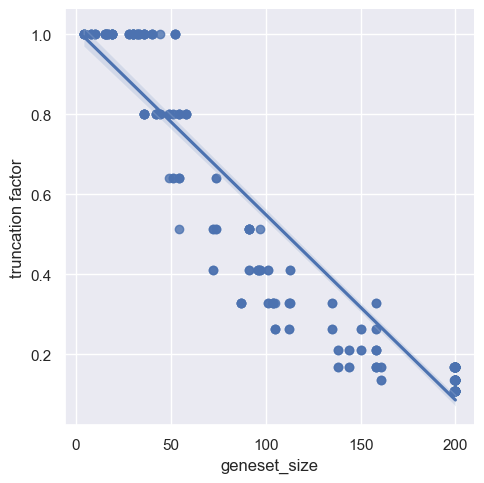

In [27]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
np.random.seed(sum(map(ord, "regression")))
sns.lmplot(x=GENESET_SIZE, y=TRUNCATION_FACTOR, data=df.query("method=='ontological_synopsis'"))
plt.show()

<Axes: xlabel='geneset_size', ylabel='truncation factor'>

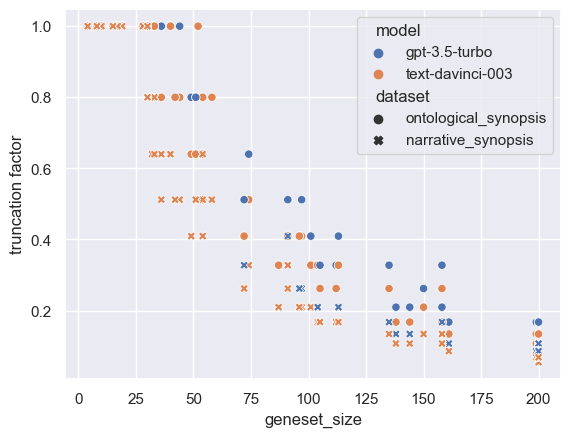

In [28]:
dftups = [(method, df.query(f"method=='{method}'")) for method in ["ontological_synopsis", "narrative_synopsis"]]
for m, mdf in dftups:
    mdf.assign(dataset=m)
concatenated = pd.concat([mdf.assign(dataset=m) for m, mdf in dftups])
sns.scatterplot(x=GENESET_SIZE, y=TRUNCATION_FACTOR, data=concatenated, style='dataset', hue='model')

In [29]:
df.query(f"{GENESET_SIZE} < 50")[[SOURCE_GENESET]].drop_duplicates()

,source geneset
0,EDS
22,FA
110,HALLMARK_ANGIOGENESIS
154,HALLMARK_APICAL_SURFACE
462,HALLMARK_HEDGEHOG_SIGNALING
...,...
1386,molecular sequestering
1430,peroxisome
1452,progeria
1474,regulation of presynaptic membrane potential


In [30]:
df_small = df.query(f"{GENESET_SIZE} < 50")
means = df_small[[MODEL, METHOD] + eval_summary_cols].groupby(['model', 'method']).mean(numeric_only=True)
means

has top hit  in top 5  in top 10  \
model            method                                                   
N/A              closure                      1.00      0.00       0.00   
                 random                       0.00      0.00       0.00   
                 rank_based                   0.05      0.00       0.00   
                 standard                     1.00      1.00       1.00   
                 standard_no_ontology         0.64      0.57       0.57   
...                                            ...       ...        ...   
gpt-3.5-turbo    no_synopsis                  0.21      0.21       0.21   
                 ontological_synopsis         0.45      0.43       0.45   
text-davinci-003 narrative_synopsis           0.10      0.10       0.10   
                 no_synopsis                  0.07      0.07       0.07   
                 ontological_synopsis         0.29      0.14       0.24   

                                       size overlap  similarity  num terms  \
model            method                                                      
N/A              closure                     126.12    7.58e-02    2422.12   
                 random                        1.07    8.70e-03      25.07   
                 rank_based                    2.57    1.68e-02      26.10   
                 standard                    126.12    9.83e-01     129.12   
                 standard_no_ontology         26.93    2.15e-01      36.05   
...                                             ...         ...        ...   
gpt-3.5-turbo    no_synopsis                   2.10    2.48e-02       4.88   
                 ontological_synopsis          2.74    3.29e-02       5.86   
text-davinci-003 narrative_synopsis            1.36    1.25e-02       9.55   
                 no_synopsis                   1.07    1.10e-02      10.45   
                 ontological_synopsis          2.02    1.99e-02      11.55   

                                       num GO terms  nr size overlap  \
model            method                                                
N/A              closure                    2378.76             3.31   
                 random                       25.07             0.38   
                 rank_based                   26.10             0.40   
                 standard                    126.12            16.29   
                 standard_no_ontology         36.05             5.81   
...                                             ...              ...   
gpt-3.5-turbo    no_synopsis                   4.07             0.69   
                 ontological_synopsis          4.76             0.93   
text-davinci-003 narrative_synopsis            3.17             0.38   
                 no_synopsis                   3.00             0.19   
                 ontological_synopsis          7.19             0.74   

                                       nr similarity  mean p value  \
model            method                                              
N/A              closure                        0.02      9.19e-01   
                 random                         0.01      9.55e-01   
                 rank_based                     0.02      9.17e-01   
                 standard                       0.98      9.45e-03   
                 standard_no_ontology           0.21      2.85e-01   
...                                              ...           ...   
gpt-3.5-turbo    no_synopsis                    0.04      4.73e-01   
                 ontological_synopsis           0.07      3.89e-01   
text-davinci-003 narrative_synopsis             0.02      5.81e-01   
                 no_synopsis                    0.01      5.78e-01   
                 ontological_synopsis           0.04      6.71e-01   

                                       min p value  max p value  \
model            method                                           
N/A              closure                  4.59e-05         1.00   

In [31]:
means.query("method != 'standard'").style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

In [32]:
agg_table(df_small, [PROPOTION_SIGNIFICANT, NUM_GO_TERMS, HAS_TOP_HIT, NUM_NOVEL], ["closure", "standard", "standard_no_ontology", "random", "rank_based"])

## Looking at individual gene sets

In [33]:

def terms_summary(df, max_rows=9999):
    term_dict = {}
    n = 0
    for _, row in df.iterrows():
        n += 1
        if n > max_rows:
            break
        model = row['model'] 
        if "turbo" in model:
            model = "turbo"
        elif "davinci" in model:
            model = "dav"
        else:
            model = ""
        method = str(row['method']).replace('_', ' ')
        if method in ["closure", "rank_based", "random"]:
            continue
        mm = f"{model} {method}"
        if method == "standard":
            nr_term_ids = list(filter_redundant(row[TERM_IDS]))
        else:
            nr_term_ids = None
        for ix, t_id in enumerate(row[TERM_IDS]):
            if t_id not in term_dict:
                t = {"id": t_id, "label": go.label(t_id), "redundant": False}
                term_dict[t_id] = t
            else:
                t = term_dict[t_id]
            t[mm] = ix
            if nr_term_ids and t_id not in nr_term_ids:
                t["redundant"] = True
    objs = list(term_dict.values())
    return pd.DataFrame(objs)

### Peroxisome

In [34]:
peroxisome = df.query(f"{GENESET} == 'peroxisome-0'").sort_values("similarity", ascending=False)
peroxisome[[MODEL, METHOD] + eval_summary_cols]

,model,method,has top hit,in top 5,in top 10,size overlap,similarity,num terms,num GO terms,nr size overlap,nr similarity,mean p value,min p value,max p value,proportion significant,num novel
1436,N/A,standard,True,True,True,62,1.00,62,62,10,1.00,5.64e-03,1.98e-16,4.11e-02,1.00,0
1437,N/A,standard_no_ontology,True,False,False,15,0.22,21,21,7,0.41,2.89e-01,1.98e-16,1.00e+00,0.71,0
1440,N/A,closure,True,False,False,62,0.19,419,391,7,0.13,8.02e-01,1.98e-16,1.00e+00,0.20,0
1431,gpt-3.5-turbo,ontological_synopsis,True,True,True,4,0.06,6,4,2,0.18,1.08e-04,1.98e-16,4.30e-04,1.00,0
1430,gpt-3.5-turbo,no_synopsis,False,False,False,2,0.03,6,3,1,0.09,3.33e-01,6.88e-15,1.00e+00,0.67,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1433,text-davinci-003,no_synopsis,False,False,False,0,0.00,6,0,0,0.00,NaN,NaN,NaN,NaN,0
1434,text-davinci-003,ontological_synopsis,False,False,False,0,0.00,1,0,0,0.00,NaN,NaN,NaN,NaN,0
1435,text-davinci-003,narrative_synopsis,False,False,False,0,0.00,5,1,0,0.00,1.00e+00,1.00e+00,1.00e+00,0.00,1
1438,N/A,random,False,False,False,0,0.00,8,8,0,0.00,1.00e+00,1.00e+00,1.00e+00,0.00,7


In [35]:
# terms_summary(peroxisome).style.highlight_min(axis=1, props='font-weight:bold', numeric_only=True)
terms_summary(peroxisome)

,id,label,redundant,standard,standard no ontology,turbo ontological synopsis,turbo no synopsis,turbo narrative synopsis,dav no synopsis,dav ontological synopsis,dav narrative synopsis,rank based
0,GO:0006625,protein targeting to peroxisome,False,0.0,10.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
1,GO:0072663,establishment of protein localization to perox...,True,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,GO:0072662,protein localization to peroxisome,True,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,GO:0015919,peroxisomal membrane transport,False,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,GO:0043574,peroxisomal transport,True,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
92,GO:0046872,metal ion binding,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
93,GO:0016020,membrane,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
94,GO:0070062,extracellular exosome,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
95,GO:0005829,cytosol,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0


## Sensory Ataxia

In [36]:
ataxia = df.query(f"{GENESET} == 'sensory ataxia-0'").sort_values("similarity", ascending=False)
ataxia[[MODEL, METHOD] + eval_summary_cols]                                                  

,model,method,has top hit,in top 5,in top 10,size overlap,similarity,num terms,num GO terms,nr size overlap,nr similarity,mean p value,min p value,max p value,proportion significant,num novel
1502,N/A,standard,True,True,True,9,1.00e+00,9,9,3,1.00,1.25e-02,1.95e-05,4.26e-02,1.00,0
1503,N/A,standard_no_ontology,False,False,False,3,3.00e-01,4,4,1,0.20,2.63e-01,3.13e-04,1.00e+00,0.75,0
1497,gpt-3.5-turbo,ontological_synopsis,True,True,True,2,2.22e-01,3,2,2,0.67,1.66e-04,1.95e-05,3.13e-04,1.00,0
1500,text-davinci-003,ontological_synopsis,True,False,False,2,1.00e-01,17,13,2,0.18,8.48e-01,1.95e-05,1.00e+00,0.15,0
1506,N/A,closure,True,False,False,9,8.51e-03,1360,1314,0,0.00,9.89e-01,1.95e-05,1.00e+00,0.01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1498,gpt-3.5-turbo,narrative_synopsis,False,False,False,0,0.00e+00,4,1,0,0.00,1.00e+00,1.00e+00,1.00e+00,0.00,0
1499,text-davinci-003,no_synopsis,False,False,False,0,0.00e+00,17,9,0,0.00,1.00e+00,1.00e+00,1.00e+00,0.00,4
1501,text-davinci-003,narrative_synopsis,False,False,False,0,0.00e+00,6,2,0,0.00,1.00e+00,1.00e+00,1.00e+00,0.00,1
1504,N/A,random,False,False,False,0,0.00e+00,14,14,0,0.00,1.00e+00,1.00e+00,1.00e+00,0.00,7


In [37]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)


In [38]:
ataxia[[MODEL, METHOD, GO_TERM_IDS, NOVEL_LABELS]]

,model,method,go term ids,novel labels
1502,N/A,standard,"[GO:0042552, GO:0008366, GO:0007272, GO:0007422, GO:0014037, GO:0010001, GO:0032287, GO:0006264, GO:0042063]",[]
1503,N/A,standard_no_ontology,"[GO:0021680, GO:0032287, GO:0006264, GO:0007422]",[]
1497,gpt-3.5-turbo,ontological_synopsis,"[GO:0042552, GO:0007422]",[]
1500,text-davinci-003,ontological_synopsis,"[GO:0007155, GO:0016567, GO:0050794, GO:0042981, GO:0006264, GO:0006839, GO:0015886, GO:0090304, GO:0034214, GO:0010595, GO:0002639, GO:0098743, GO:0042552]",[]
1506,N/A,closure,"[GO:0140018, GO:0008045, GO:0009612, GO:0006259, GO:0030534, GO:0075732, GO:0002639, GO:0006268, GO:0046872, GO:0003700, GO:0030218, GO:0043161, GO:0048168, GO:0032287, GO:0043139, GO:0008285, GO:0004860, GO:0051402, GO:0000978, GO:0031643, GO:0060170, GO:0018158, GO:1904390, GO:1901184, GO:0007028, GO:0003682, GO:0005261, GO:0071260, GO:0051603, GO:0014037, GO:0004347, GO:0021666, GO:0048029, GO:0006418, GO:0008033, GO:0004561, GO:0007599, GO:0061665, GO:0006915, GO:0061630, GO:0043005, GO:0008408, GO:0005654, GO:0007622, GO:0046686, GO:0006812, GO:0036494, GO:0030154, GO:0002196, GO:0003674, GO:0043657, GO:0021675, GO:0010595, GO:0008366, GO:0042982, GO:1903912, GO:0034285, GO:0006261, GO:0031410, GO:0006986, GO:0003220, GO:0035578, GO:0016485, GO:0010977, GO:0016887, GO:0034142, GO:0071310, GO:1990837, GO:0060323, GO:0005759, GO:0071897, GO:0016567, GO:1904389, GO:0071407, GO:0043524, GO:0060173, GO:0008270, GO:0005789, GO:0048704, GO:0032060, GO:0005829, GO:0055085, GO:0015232, GO:0019901, GO:0005975, GO:0042564, GO:0035640, GO:0007611, GO:0021665, GO:0007165, GO:0032288, GO:0035264, GO:0042474, GO:0005643, GO:0006801, GO:0043231, GO:0043154, GO:0042645, GO:0035284, GO:0001701, ...]",[]
1496,gpt-3.5-turbo,no_synopsis,"[GO:0031175, GO:0043209, GO:0005759]",[]
1498,gpt-3.5-turbo,narrative_synopsis,[GO:0043209],[]
1499,text-davinci-003,no_synopsis,"[GO:0007399, GO:0006119, GO:0006626, GO:0051604, GO:0045056, GO:0016192, GO:0000902, GO:0007163, GO:0030182]","[oxidative phosphorylation, protein targeting to mitochondrion, transcytosis, establishment or maintenance of cell polarity]"
1501,text-davinci-003,narrative_synopsis,"[GO:0009117, GO:0007165]",[nucleotide metabolic process]
1504,N/A,random,"[GO:0021854, GO:0005654, GO:0007049, GO:0005737, GO:0005634, GO:0045087, GO:0071333, GO:0000139, GO:0033612, GO:0031982, GO:0019941, GO:0017018, GO:0000184, GO:0005743]","[hypothalamus development, cell cycle, innate immune response, Golgi membrane, receptor serine/threonine kinase binding, myosin phosphatase activity, nuclear-transcribed mRNA catabolic process, nonsense-mediated decay]"


In [39]:
terms_summary(ataxia)

,id,label,redundant,standard,turbo ontological synopsis,dav ontological synopsis,standard no ontology,turbo no synopsis,turbo narrative synopsis,dav no synopsis,dav narrative synopsis,rank based
0,GO:0042552,myelination,False,0.0,0.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN
1,GO:0008366,axon ensheathment,True,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,GO:0007272,ensheathment of neurons,True,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,GO:0007422,peripheral nervous system development,False,3.0,1.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN
4,GO:0014037,Schwann cell differentiation,True,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,GO:0010001,glial cell differentiation,True,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,GO:0032287,peripheral nervous system myelin maintenance,True,6.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
7,GO:0006264,mitochondrial DNA replication,False,7.0,NaN,6.0,2.0,NaN,NaN,NaN,NaN,NaN
8,GO:0042063,gliogenesis,True,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,GO:0021680,cerebellar Purkinje cell layer development,False,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN


In [40]:
def retrieve_payload(geneset, method):
    for comp in comps:
        if comp.name == geneset:
            return comp.payloads[method]

In [41]:
print(retrieve_payload("sensory ataxia-0", "gpt-3.5-turbo.ontological_synopsis").response_text)

Summary: Genes are mostly involved in nerve function and diseases, especially Charcot-Marie-Tooth disease.

Mechanism: The genes are all involved in the process of myelination of nerve cells and other nervous system processes.

Enriched Terms: Myelination; peripheral nervous system development; nerve impulse transmission


In [42]:
print(retrieve_payload("sensory ataxia-0", "gpt-3.5-turbo.narrative_synopsis").response_text)

Summary: Genes are mostly involved in the maintenance and function of peripheral nerves in the human body.
Mechanism: Myelination and proper function of Schwann cells in peripheral nerves.

Enriched Terms: Charcot-Marie-Tooth disease; Dejerine-Sottas syndrome; peripheral neuropathy; myelin sheath.

Hypothesis: These genes are involved in the proper formation and maintenance of myelin sheaths in peripheral nerves, as mutations in these genes result in various forms of peripheral neuropathies, such as Charcot-Marie-Tooth disease and Dejerine-Sottas syndrome. Dysfunction in the myelin sheath formation or maintenance can lead to disrupted nerve conduction and neuropathy.


In [43]:
print(retrieve_payload("sensory ataxia-0", "gpt-3.5-turbo.no_synopsis").response_text)

Summary: This set of genes is enriched for functions related to nervous system development and maintenance, as well as mitochondrial metabolism.

Mechanism: These genes likely play roles in maintaining the proper functioning of neurons and supporting cells and in energy production in mitochondria.

Enriched Terms: neuron projection development; myelin sheath; mitochondrial matrix; mitochondrial respiratory chain complex; mitochondrial metabolism.


## Endocytosis

In [44]:
endocytosis = df.query(f"{GENESET} == 'endocytosis-0'").sort_values("similarity", ascending=False)
terms_summary(endocytosis)

,id,label,redundant,standard,standard no ontology,turbo ontological synopsis,turbo no synopsis,turbo narrative synopsis,dav narrative synopsis,dav no synopsis,rank based,dav ontological synopsis
0,GO:0006907,pinocytosis,False,0.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
1,GO:0006897,endocytosis,True,1.0,6.0,0.0,0.0,0.0,20.0,NaN,NaN,NaN
2,GO:0044351,macropinocytosis,True,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,GO:0016192,vesicle-mediated transport,True,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,GO:0030100,regulation of endocytosis,False,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,GO:0006810,transport,True,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,GO:0051234,establishment of localization,True,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,GO:0045807,positive regulation of endocytosis,True,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,GO:0060627,regulation of vesicle-mediated transport,True,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,GO:0051179,localization,True,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
print(retrieve_payload("endocytosis-0", "gpt-3.5-turbo.narrative_synopsis").prompt)


I will give you a list of genes together with descriptions of their functions.
Perform a term enrichment test on these genes.
i.e. tell me what the commonalities are in their function.
Make use of classification hierarchies when you do this.
Only report gene functions in common, not diseases.
e.g if gene1 is involved in "toe bone growth" and gene2 is involved in "finger morphogenesis"
then the term "digit development" would be enriched as represented by gene1 and gene2.
Only include terms that are statistically over-represented.
Also include a hypothesis of the underlying biological mechanism or pathway.

Provide results in the format

Summary: <high level summary>
Mechanism: <mechanism>
Enriched Terms: <term1>; <term2>; <term3>

###

Here are the gene summaries:
DOCK2: The protein encoded by this gene belongs to the CDM protein family. It is specifically expressed in hematopoietic cells and is predominantly expressed in peripheral blood leukocytes. The protein is involved in remodeli

In [37]:
print(retrieve_payload("endocytosis-0", "gpt-3.5-turbo.narrative_synopsis").response_text)

Summary: Genes involved in intracellular trafficking, endocytosis, and cytoskeletal reorganization processes are enriched.

Mechanism: These genes likely play a role in the regulation and organization of cellular processes through the endocytic pathway and cytoskeleton.

Enriched Terms: Endocytosis; Cytoskeleton organization; Intracellular trafficking.


In [38]:
print(retrieve_payload("endocytosis-0", "gpt-3.5-turbo.ontological_synopsis").prompt)


I will give you a list of genes together with descriptions of their functions.
Perform a term enrichment test on these genes.
i.e. tell me what the commonalities are in their function.
Make use of classification hierarchies when you do this.
Only report gene functions in common, not diseases.
e.g if gene1 is involved in "toe bone growth" and gene2 is involved in "finger morphogenesis"
then the term "digit development" would be enriched as represented by gene1 and gene2.
Only include terms that are statistically over-represented.
Also include a hypothesis of the underlying biological mechanism or pathway.

Provide results in the format

Summary: <high level summary>
Mechanism: <mechanism>
Enriched Terms: <term1>; <term2>; <term3>

###

Here are the gene summaries:
DOCK2: Enables T cell receptor binding activity and guanyl-nucleotide exchange factor activity. Predicted to be involved in several processes, including macropinocytosis; myeloid dendritic cell activation involved in immune r

## Hallucinations

In [73]:
def hallucinatons(df, model):
    novel_term_map = defaultdict(dict)
    for _, row in df.iterrows():
        gs = row[GENESET]
        #if not gs.endswith("-0"):
        #    continue
        gs = gs.replace("-0", "")
        for lbl in row[NOVEL_LABELS]:
            if row[MODEL] != model:
                continue
            m = row[METHOD]
            novel_term_map[lbl]["NAME"] = lbl
            if gs not in novel_term_map[lbl]:
                novel_term_map[lbl][m] = []
            novel_term_map[lbl][m].append(gs)
    novel_df = pd.DataFrame(novel_term_map.values())
    return novel_df

In [74]:
novel_df_turbo = hallucinatons(df, TURBO)
novel_df_turbo

,NAME,no_synopsis,narrative_synopsis,ontological_synopsis
0,response to vitamin E,[EDS],NaN,NaN
1,regulation of collagen catabolic process,[EDS],NaN,NaN
2,negative regulation of collagen biosynthetic process,[EDS],NaN,NaN
3,Golgi organization,[HALLMARK_HEDGEHOG_SIGNALING],NaN,NaN
4,positive regulation of JNK cascade,[HALLMARK_HEDGEHOG_SIGNALING],NaN,NaN
5,glycogen catabolic process,[HALLMARK_MTORC1_SIGNALING],NaN,NaN
6,proton motive force-driven mitochondrial ATP synthesis,NaN,[HALLMARK_MTORC1_SIGNALING-1],NaN
7,regulation of stem cell differentiation,[Yamanaka-TFs],NaN,NaN
8,regulation of cell growth,[Yamanaka-TFs-1],NaN,NaN
9,"obsolete transcription factor activity, protein binding",[bicluster_RNAseqDB_0-1],[tf-downreg-colorectal-1],[bicluster_RNAseqDB_0-1]


In [75]:
hallucinatons(df, DAVINCI)

,NAME,no_synopsis,narrative_synopsis,ontological_synopsis
0,protein folding,[EDS],[amigo-example-1],NaN
1,cell adhesion mediator activity,[EDS],NaN,NaN
2,co-receptor binding,[EDS-1],NaN,NaN
3,cell growth,[FA],[bicluster_RNAseqDB_1002-1],NaN
4,DNA-templated transcription,NaN,[progeria],[FA-1]
5,obsolete matrilysin activity,NaN,[HALLMARK_APICAL_JUNCTION],NaN
6,obsolete tumor suppressor,NaN,[HALLMARK_APICAL_JUNCTION],NaN
7,obsolete calcium-dependent cell adhesion molecule activity,NaN,[HALLMARK_APICAL_JUNCTION-1],NaN
8,arachidonate 15-lipoxygenase activity,NaN,NaN,[HALLMARK_GLYCOLYSIS]
9,histone acetylation,NaN,[HALLMARK_GLYCOLYSIS],NaN


## New Annotations

In [39]:
endocytosis = df.query(f"{GENESET} == 'endocytosis-0'").sort_values("similarity", ascending=False)
terms_summary(endocytosis)

,id,label,redundant,standard,standard no ontology,turbo gpt-3.5-turbo.ontological synopsis,dav text-davinci-003.narrative synopsis,dav text-davinci-003.ontological synopsis,turbo gpt-3.5-turbo.narrative synopsis,turbo gpt-3.5-turbo.no synopsis,rank based,dav text-davinci-003.no synopsis,random
0,GO:0006907,pinocytosis,False,0.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,GO:0006897,endocytosis,True,1.0,6.0,0.0,1.0,13.0,0.0,1.0,NaN,NaN,NaN
2,GO:0044351,macropinocytosis,True,2.0,0.0,NaN,5.0,3.0,NaN,NaN,NaN,NaN,NaN
3,GO:0016192,vesicle-mediated transport,True,3.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
4,GO:0030100,regulation of endocytosis,False,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,GO:0006810,transport,True,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,GO:0051234,establishment of localization,True,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,GO:0045807,positive regulation of endocytosis,True,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,GO:0060627,regulation of vesicle-mediated transport,True,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,GO:0051179,localization,True,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### New Annotations

in 2022-03-24, GO `molecular sequesting` only had 6 genes annotated; this increased to 30 in 2023.
If these are past the LLM training date then we would not expect these to influence results. Additionally,


In [40]:
sequestering = df.query(f"{GENESET} == 'molecular sequestering-0'").sort_values("similarity", ascending=False)
sequestering[eval_summary_cols]                                                           

,model,method,has top hit,in top 5,in top 10,size overlap,similarity,num terms,nr size overlap,nr similarity
686,N/A,standard,True,True,True,26,1.00,26,10,1.00
687,N/A,standard_no_ontology,True,True,True,9,0.28,15,2,0.11
680,gpt-3.5-turbo,gpt-3.5-turbo.no_synopsis,False,False,False,1,0.03,10,1,0.07
689,N/A,rank_based,False,False,False,1,0.02,30,0,0.00
681,gpt-3.5-turbo,gpt-3.5-turbo.ontological_synopsis,False,False,False,0,0.00,3,0,0.00
682,gpt-3.5-turbo,gpt-3.5-turbo.narrative_synopsis,False,False,False,0,0.00,6,0,0.00
683,text-davinci-003,text-davinci-003.no_synopsis,False,False,False,0,0.00,9,0,0.00
684,text-davinci-003,text-davinci-003.ontological_synopsis,False,False,False,0,0.00,7,0,0.00
685,text-davinci-003,text-davinci-003.narrative_synopsis,False,False,False,0,0.00,6,0,0.00
688,N/A,random,False,False,False,0,0.00,29,0,0.00


In [41]:
terms_summary(sequestering)

,id,label,redundant,standard,standard no ontology,turbo gpt-3.5-turbo.no synopsis,rank based,dav text-davinci-003.narrative synopsis,random,turbo gpt-3.5-turbo.ontological synopsis,dav text-davinci-003.no synopsis,turbo gpt-3.5-turbo.narrative synopsis,dav text-davinci-003.ontological synopsis
0,GO:0140313,molecular sequestering activity,False,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,GO:0140311,protein sequestering activity,True,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,GO:0140487,metal ion sequestering activity,True,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,GO:0048519,negative regulation of biological process,False,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,GO:0006950,response to stress,False,4.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,GO:0048523,negative regulation of cellular process,True,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,GO:0140678,molecular function inhibitor activity,False,6.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,GO:0048585,negative regulation of response to stimulus,True,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,GO:0036316,SREBP-SCAP complex retention in endoplasmic reticulum,True,8.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,GO:0140315,iron ion sequestering activity,True,9.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## IGRB

This gene set contains genes previously annotated to IGRB, many of which have been since removed

In [42]:
igrb = df.query(f"{GENESET} == 'ig-receptor-binding-2022-0'").sort_values("similarity", ascending=False)
terms_summary(igrb)

,id,label,redundant,standard,standard no ontology,rank based,random,turbo gpt-3.5-turbo.no synopsis,turbo gpt-3.5-turbo.ontological synopsis,turbo gpt-3.5-turbo.narrative synopsis,dav text-davinci-003.narrative synopsis,dav text-davinci-003.ontological synopsis,dav text-davinci-003.no synopsis
0,GO:0019814,immunoglobulin complex,False,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,GO:0009897,external side of plasma membrane,False,1.0,0.0,79.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,GO:0098552,side of membrane,True,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,GO:0002250,adaptive immune response,False,3.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,GO:0009986,cell surface,True,4.0,NaN,23.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN
5,GO:0006955,immune response,True,5.0,6.0,42.0,NaN,4.0,0.0,1.0,NaN,NaN,NaN
6,GO:0002376,immune system process,True,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,GO:0005886,plasma membrane,True,7.0,NaN,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,GO:0071944,cell periphery,True,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,GO:0003823,antigen binding,False,9.0,4.0,NaN,NaN,3.0,NaN,NaN,0.0,NaN,NaN


## Summaries

In [43]:
objs = []
for c in comps:
    for m, payload in c.payloads.items():
        if payload.summary:
            objs.append({"model": c.model, "geneset": c.name, "method": m, "summary": payload.summary})

In [44]:
sdf = pd.DataFrame(objs)

In [45]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
sdf

In [46]:
sdf.query("geneset == 'sensory ataxia-0'")

,model,geneset,method,summary
528,None,sensory ataxia-0,gpt-3.5-turbo.no_synopsis,"Summary: Enriched terms are related to myelin sheath formation, neuronal development, and protein processing.\n"
529,None,sensory ataxia-0,gpt-3.5-turbo.ontological_synopsis,"Summary: These genes are involved in various processes related to the peripheral nervous system and nucleic acid metabolism, including myelination, DNA replication, and protein ubiquitination.\nMechanism: These genes may be involved in the maintenance, repair, and regulation of the peripheral nervous system and nucleic acids.\n"
530,None,sensory ataxia-0,gpt-3.5-turbo.narrative_synopsis,"Summary: Genes are involved in various neurological and metabolic disorders. Enriched terms include ""peripheral nervous system development,"" ""neurological system process,"" and ""mitochondrial DNA replication.""\n\nMechanism: The enriched terms suggest a common theme of neurological and metabolic dysfunction related to the peripheral nervous system and mitochondrial function.\n\n"
531,None,sensory ataxia-0,text-davinci-003.no_synopsis,Summary: The given genes are enriched for proteins in cytoskeleton organization and signaling; glycoprotein metabolism and signaling; and ion channel activity and signaling. \n
532,None,sensory ataxia-0,text-davinci-003.ontological_synopsis,"Summary: Enriched terms were found for proteins involved in cellular processes such as membrane transport, apoptotic regulation, transcription regulation, intracellular protein transport, DNA/RNA processing, mitochondrial transport, and sensory perception. \n\nMechanism: These proteins likely act as components of the intracellular transport machinery and are involved in multiple processes such as protein folding, DNA/RNA processing, and protein ubiquitination. They may also form complexes to regulate the transcription machinery and regulate cell apoptosis.\n\n"
533,None,sensory ataxia-0,text-davinci-003.narrative_synopsis,"\nSummary: Genes involved in Charcot-Marie-Tooth diseases, neurological disorders, and other hematological conditions have been identified. \nMechanism: Genes related to peripheral nerve myelin upkeep, mitochondrial DNA polymerase, E3 ubiquitin ligase, DNA helicase, GPI-Moonlighting proteins, Nuclear pore complex and transcription factor are involved in maintaining neuronal activity, replication of mitochondrial DNA, protein ubiquitination, unwinding of double-stranded DNA, glycolysis and transcription of proteins, which are all essential for proper nerve conduction and maintenance of health cells. \n"
540,None,sensory ataxia-0,gpt-3.5-turbo.no_synopsis,Summary: The common function of the genes appears to be related to neurological processes and protein metabolism. \n\n
541,None,sensory ataxia-0,gpt-3.5-turbo.ontological_synopsis,Summary: Genes are commonly involved in peripheral nervous system myelination and neuromuscular diseases.\nMechanism: These genes are involved in the proper development and maintenance of the peripheral nervous system.\n
542,None,sensory ataxia-0,gpt-3.5-turbo.narrative_synopsis,"Summary: Genes are primarily involved in peripheral nervous system function and diseases, specifically Charcot-Marie-Tooth disease and related neuropathies. \nMechanism: Possibly related to myelin maintenance and/or nerve impulse transmission in the peripheral nervous system. \n"
543,None,sensory ataxia-0,text-davinci-003.no_synopsis,"\nSummary: The list of genes provided are involved in wide range of functions such as regulation of cell signaling pathways, chromatin remodeling, structure and organization of nervous system, lipid metabolic processes, cation transport and intra-cellular transport of proteins.\n\n"
